#  2020 US Presidential Elections Results Simulation

> By: Andrew Yang, Dorina Alimadhi, Edward Henriquez, Dilip Jagannathan Seshadri


## Introduction

Millions of Americans head to their local polling station every four years and exercise their right to vote. Deeply woven into the civic duty on Election Day are polls. 

Polls are conducted by third parties that go out and survey states across the United States. Poll results provide how the respondents are likely to vote for at the time the poll was conducted. Polls play an even more critical role in the 2020 Election between the incumbent **President Donald Trump** (Republican Party) and the former Vice President **Joe Biden** (Democratic Party). The polls importance this election is because of what happened in the 2016 election, which saw Donald Trump upset what was believed to be the favorite Hilary Clinton.  

Our project revolves around these polls, but the context around the electoral process is needed.

## The Electoral Process

- The President is not elected directly by citizens. The president is chosen by “electors” in the Electoral College.

- Except for two — Nebraska and Maine — states are winner-take-all in the electoral college. *Meaning:* the candidate with the most popular votes in that state gets all the electoral college votes that states have.

- To win the election, a candidate must receive 270 or more electoral college votes out of a total of 538 available.

- Each state has a certain number of electoral college votes based on a number of factors. These aren’t pertinent to our study but click here if you’d like to learn more about the electoral college and the vote distribution.  

## Our Project

The primary goal of our project was to analyze polls from across the country and answer the following questions:

1. What will be the final electoral college score?  

2. What are Biden’s chances of winning?  

3. What states are “battleground” states? How are the polls moving in those states? 


## Methodology

Our project sourced the polling data from the polling website [270toWin](https://www.270towin.com/). Per the 270toWin website: 

> "270toWin is a nonpartisan site for people passionate about politics. We aggregate polls and professional election projections, complementing that with relevant news and original content. Visitors to the site use this information to create and share their election forecasts via our engaging interactive mapping tools." 

In addition, we used pollster data from [FiveThirtyEight](https://fivethirtyeight.com/) — a website dedicated to politics and leveraging data to make predictions on events such as the elections. We deemed them a reputable source as they are respected and trusted across the media. To view the data used, click [here](https://projects.fivethirtyeight.com/pollster-ratings/). 

Our steps involved the following:

**Step 1**: Using Python and several packages within Python, we scraped the polling data for each state (File: parse_data_from_site.py). The result of the scrape included:

- List of the polls conducted in the state  

- The date the poll was conducted

- The polls' sample size — the number of people polled 

- The results — how many would vote for Trump and how many would vote for Biden as a percentage (%).  

**NOTE:** if the results didn't add up to 100% — i.e., the presence of a third-party candidate — we split the difference and awarded them to each candidate. 

    
**Step 2**: We downloaded the pollster information with grades as text file and we combined the poll data and assigned it a grade based on FiveThirtyEight's grading  scheme. (File: convert_data_to_dataframe.py). We also parsed the electoral votes information of each state from the text file by downloading it from the site.


**Step 3**: Using this final notebook, we then had to simulate the results for each state with all the above data. We decided to use the most recent poll data (date-wise) with a pollster grade in the range of *A+ to B-*. We deemed this criteria appropirate because we want to be using data from reputable sources while at the same time being timely and taking into account a possible swing in a given state. If there was a state that didn't have a pollster with a grade in that range, we decided to use the most recent poll. We simulated the results 1,000 times for each state using normal distribution (based on the assumptions mentioned in the assumptions section) with the poll details selected based on the rule mentioned above and calculated the percentage of wins based on number of times Biden or Trump won in that state divided by 1000. We determine the winner of the state in one simulation if the percent is greater than 50%. Let p be the proportion of voters that will vote for candidate A. We defined swing states as those whose margin of victory was between 0.25-0.75% for either candidate. We deemed this margin of victory sufficient and in line with what is typically considered swing states ~4-7 states. In introductory statistics, we learn that the sample proportion $ \widehat{p} $ (survey result) is an estimate for p and moreover that $ \widehat{p} $ follows a normal distribution (if $ np\geq 10$) with standard deviation:

<div align="center">$ \sigma \widehat{p}=\sqrt{\dfrac{p\left( 1-p\right) }{n}} $</div>
                              


## Assumptions

1. Two states are not winner-take-all in the electoral college (Nebraska and Maine). But we are treating them as winner-take-all.

2. When a poll's numbers sum to less than 100%, which is likely the case in all polls, split the remaining difference equally between these two candidates. If there are any other third parties in a particular state, we distribute the vote percent evenly between Trump and Biden.

3. Each poll result contains the sample size. It's the number before either LV (likely voters) and RV (registered) voters. We will ignore the LV vs RV distinction and just record poll size in our data frame.

4. We treat every state win as independent and not correlated to one another even though in reality, it is not. Given the sample size is greater than 30, we assume normal distribution for our polls.



In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Oct  8 23:05:22 2020

@author: Andrew Yang, Dorina Alimadhi, Edward Henriquez, Dilip Jagannathan Seshadri
"""
import numpy as np
import sys
import os
import pandas as pd
from scipy import stats
import geopandas
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.lines as mlines
import matplotlib.dates as mdates
from IPython.core.display import display, HTML
'''
--------------------------------------------------------------------------------------------- 
Create dataframe of the electoral votes for each state
--------------------------------------------------------------------------------------------- 
'''                
def find_best_rule_for_simulating_results(filter_df):
    filter_df = filter_df.sort_values(by=['Poll Date'] , ascending=[False])
    filter_df_for_grades = filter_df[filter_df['Poll Source Grade'].str.contains('A|B', na=False)]
    if not filter_df_for_grades.empty:
        return filter_df_for_grades.head(1)
    else:
        return filter_df.head(1)
    
    

'''
--------------------------------------------------------------------------------------------- 
Create dataframe of the electoral votes for each state
--------------------------------------------------------------------------------------------- 
'''                
def simulate_election_results(filter_df):
    results_df = pd.DataFrame(columns=['State', 'Poll Source','Poll Date', 'Poll Source Grade',
                                 'Party','Poll Source Bias'])
    
    # Rule to pick the top row ordered by most recent date and grade in A or B. If nothing is in 
    # A or B for that state, then pick the top date

    best_poll_based_on_rule = find_best_rule_for_simulating_results(filter_df)
    election_distribution_for_the_poll = stats.norm(best_poll_based_on_rule.Estimated_Biden, 
                                                    best_poll_based_on_rule.Estimated_StdDev)

    results = simulate_results(election_distribution_for_the_poll, 1000)
    
    results_df['State'] = best_poll_based_on_rule.State
    results_df['Poll Source'] = best_poll_based_on_rule['Poll Source']
    results_df['Poll Date'] = best_poll_based_on_rule['Poll Date']
    results_df['Poll Source Grade'] = best_poll_based_on_rule['Poll Source Grade']
    results_df['Party'] = best_poll_based_on_rule['Party']
    results_df['Poll Source Bias'] = best_poll_based_on_rule['Poll Source Bias']

    i = 0
    biden_win_count = 0
    trump_win_count = 0
    for value in results:
        results_df[str(i+1)] = value
        if (float(value) > 0.5):
            biden_win_count += 1
        else:
            trump_win_count += 1
        i = i + 1
    biden_win_percent = biden_win_count / 1000
    trump_win_percent = trump_win_count / 1000
    results_df['Simulated Biden Win Percent'] = biden_win_percent
    results_df['Simulated Trump Win Percent'] = trump_win_percent

    return results_df
            
        
'''
--------------------------------------------------------------------------------------------- 
Generate results based on number of simulations requested
--------------------------------------------------------------------------------------------- 
'''       
def simulate_results(election_distribution_for_the_poll, n):  
    return election_distribution_for_the_poll.rvs(n)

'''
--------------------------------------------------------------------------------------------- 
Plot Visual #1: Map of the US that conveys who is likely to win each state
--------------------------------------------------------------------------------------------- 
'''
def plot_us_map_with_state_winner(votes_states_df):

    states = geopandas.read_file(str(file_path) + '/states/states.shp')

    #convert to Mercator projection
    states = states.to_crs("EPSG:3395")

    continental = states[states.STATE_ABBR.isin(['AK', 'HI']) == False]

    fig, ax = plt.subplots(figsize=(14, 14))
    continental.plot(ax=ax, color='darkgrey', edgecolor='black')

    for state in continental.index:
        ax.annotate(text = continental.STATE_ABBR[state], xy = (continental.geometry[state].centroid.x,
                                                             continental.geometry[state].centroid.y),
                    ha = 'center', fontsize=10)
        current_state = states[states['STATE_NAME'] == continental['STATE_NAME'].iloc[state - 1]]
        if continental['STATE_NAME'].iloc[state - 1] in votes_states_df['State'].values:
            current_state.plot(ax=ax, edgecolor='black', color=votes_states_df.loc[votes_states_df['State'] == continental['STATE_NAME'].iloc[state - 1], 'Color'])


    # Set a title for the plot
    plt.title(label='Projected Winner Of Each State',fontsize=30)     

    # Create the legend
    democrat_likely = mlines.Line2D([], [], color='royalblue', marker='s', linestyle='None',
                              markersize=10, label='Biden: Likely')
    democrat_leans = mlines.Line2D([], [], color='lightskyblue', marker='s', linestyle='None',
                              markersize=10, label='Biden: Leans')    
    battleground = mlines.Line2D([], [], color='burlywood', marker='s', linestyle='None',
                              markersize=10, label='Battleground State')      
    republican_leans = mlines.Line2D([], [], color='salmon', marker='s', linestyle='None',
                              markersize=10, label='Trump: Leans')    
    republican_likely = mlines.Line2D([], [], color='red', marker='s', linestyle='None',
                              markersize=10, label='Trump: Likely')
    
    plt.legend(handles=[democrat_likely, democrat_leans, 
                        battleground,
                        republican_leans, republican_likely], loc="lower right")

    plt.axis('off')

    ax_AK = inset_axes(ax, width="25%", height="25%", loc="lower left", borderpad=0)
    alaska = states[states['STATE_NAME'] == 'Alaska']
    alaska.plot(ax=ax_AK, edgecolor='black', color=votes_states_df.loc[votes_states_df['State'] == 'Alaska', 'Color'])

    ax_AK.annotate(text = "AK", xy = (alaska.geometry.centroid.x, 
                                    alaska.geometry.centroid.y), ha = 'center', fontsize=10)



    ax_AK.set_xticks([])
    ax_AK.set_yticks([])
    ax_AK.axis('off')

    ax_HI = inset_axes(ax, bbox_to_anchor=(.2, 0, 1, 1),
                       bbox_transform=ax.transAxes, width="15%", height="15%", loc="lower left", borderpad=0)
    hawaii = states[states['STATE_NAME'] == 'Hawaii']
    hawaii.plot(ax=ax_HI, edgecolor='black', color=votes_states_df.loc[votes_states_df['State'] == 'Hawaii', 'Color'])

    ax_HI.annotate(text = "HI", xy = (hawaii.geometry.centroid.x, 
                                    hawaii.geometry.centroid.y), 
                                    ha = 'center', 
                                    fontsize=10)

    ax_HI.set_xticks([])
    ax_HI.set_yticks([])
    ax_HI.axis('off') 
    plt.show()    
            
'''
--------------------------------------------------------------------------------------------- 
Plot Visual #2: Histogram with total number of electoral votes for Biden
--------------------------------------------------------------------------------------------- 
'''
def plot_histogram_with_biden_votes(electoral_votes_for_biden_df):

    plt.figure(figsize=(12, 9))  
    # Set a title for the plot   
    
    ax = plt.subplot(111)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    plt.xlabel("Total Electoral Votes", fontsize=16)
    plt.ylabel("#Samples", fontsize=16)
    plt.xticks(range(0,538,25), fontsize=14)  
    plt.yticks(range(0,500,25), fontsize=14)
    plt.title(label='Simulated Distribution of Total Electoral Votes for Biden',fontsize=30) 
    heights, bins, _ = plt.hist(electoral_votes_for_biden_df.Total_Biden_Votes,  bins=100)
    bin_width = np.diff(bins)[0]
    bin_pos = bins[:-1] + bin_width / 2
    mask = (bin_pos >= 270)

    # plot data in two steps
    plt.bar(bin_pos[mask], heights[mask], width= bin_width,color='b', edgecolor='k')
    plt.bar(bin_pos[~mask], heights[~mask], width= bin_width, color='r', edgecolor='k')
    plt.axvline(x=270, linestyle='--',linewidth=1, color='grey')
    plt.show()
    
'''
--------------------------------------------------------------------------------------------- 
Filter results for battleground state
--------------------------------------------------------------------------------------------- 
'''    
def poll_results_over_time(battleground_state,state_name):

    # Remove Polls run prior to May 1st 2020
    battleground_state = battleground_state[battleground_state['Poll Date'] >= '2020-05-01']
    # Filter out the state for which we want to see results
    battleground_state = battleground_state.loc[battleground_state['State'] == state_name]

    # delete some of the extra columns that we are not interested in
    del battleground_state['Poll Source']
    del battleground_state['New_Source']
    del battleground_state['Sample Size']
    del battleground_state['Other']
    del battleground_state['State']

    # convert Trump and Biden porportions into float datatype
    battleground_state['Reported proportion for Biden'] = battleground_state['Reported proportion for Biden'].astype(
        dtype=float)
    battleground_state['Reported proportion for Trump'] = battleground_state['Reported proportion for Trump'].astype(
        dtype=float)

    battleground_state['Poll Date'] = pd.to_datetime(battleground_state['Poll Date'], format='%Y-%m-%d')
    # For each date if there are more than 1 polls available on that particular date get the mean of Trumnps and Biden reported porportions.
    battleground_state = battleground_state.groupby('Poll Date', as_index=False, sort=False)[
        ['Reported proportion for Biden', 'Reported proportion for Trump']].mean()
    # print (battleground_state)
    # Create a Pandas data frame that would contain all possible dates between May 1st 2020(whatever date we are chosing earlier) up until Nov 03
    Dates2020 = pd.DataFrame(columns=['Poll Date'])
    Dates2020['Poll Date'] = pd.date_range(start="2020-05-01", end="2020-11-02")
    Dates2020['Poll Date'] = pd.to_datetime(Dates2020['Poll Date'], format='%Y-%m-%d')

    # Create a final battleground_state data frame that combineds all possible dataes and poll results whenever that is available
    final_battleground_state = pd.merge(left=battleground_state, right=Dates2020, how="right", left_on='Poll Date',
                                        right_on='Poll Date')
    final_battleground_state = final_battleground_state.sort_values(by='Poll Date', ascending=True)
    # If we don't have any poll results between 2 dates we are backilling polls results from our last available date untill the next new polls are available.
    # We have decided earlier to choose POlls starting from May 1st. so if the first poll date available for one state is sometime after this date we are using these polls results to fill in the dates from the date we got the poll results till May 1st
    final_battleground_state = final_battleground_state.ffill().bfill()

    # final_battleground_state.to_csv(FilePath + 'final_battleground_state_arizona.csv')
    # print(final_battleground_state)

    return final_battleground_state  
'''
--------------------------------------------------------------------------------------------- 
Plot Visual #3: Timeseries of battleground states
--------------------------------------------------------------------------------------------- 
'''
def plot_timeseries_for_battleground_States (poll_df, swing_states):

    number_of_battleground_states = len(swing_states)

    fig , battleground_state_view = plt.subplots(nrows=number_of_battleground_states, figsize=(12, 9*number_of_battleground_states), sharex=True, sharey=True)
    for state_name in swing_states:
        index = swing_states.index(state_name)
        in_process_data_set = poll_results_over_time(poll_df,state_name)
        battleground_state_view[index].plot(in_process_data_set['Poll Date'],in_process_data_set['Reported proportion for Trump'], label='Trump', color='red')
        battleground_state_view[index].plot(in_process_data_set['Poll Date'],in_process_data_set['Reported proportion for Biden'], label='Biden', color='blue')

        battleground_state_view[index].set_title(state_name.upper(), size=14)  # here I am setting the title of each subplot to be the category
        battleground_state_view[index].set_ylabel('Poll Results', size=10)  # setting the ylabel and font size
        battleground_state_view[index].tick_params(axis='x', bottom=True, labelbottom=True, direction='in')
        #Add legend and Format horizontal axis
        battleground_state_view[index].legend(loc=0, bbox_to_anchor=(1,1))
        battleground_state_view[index].xaxis.set_major_locator(mdates.MonthLocator())
        battleground_state_view[index].xaxis.set_minor_locator(mdates.DayLocator())
        monthFmt = mdates.DateFormatter('%b')
        battleground_state_view[index].xaxis.set_major_formatter(monthFmt)

        # The idea here is to add polls closing results
        # ending_poll_results = (in_process_data_set['Poll Date'] == in_process_data_set['Poll Date'].max()) #filter to find the latest data point for the respective country
        Trump_ending_poll_results = in_process_data_set['Reported proportion for Trump'].iloc[-1]
        Biden_ending_poll_results = in_process_data_set['Reported proportion for Biden'].iloc[-1]
        battleground_state_view[index].annotate("{:.0%}".format(Trump_ending_poll_results/100), xy=(in_process_data_set['Poll Date'].max(),in_process_data_set['Reported proportion for Trump'].iloc[-1]),xycoords = 'data', ha ='left', va='top', fontsize=8) #adding the datapoint to the subplot
        battleground_state_view[index].annotate("{:.0%}".format(Biden_ending_poll_results/100), xy=(in_process_data_set['Poll Date'].max(), in_process_data_set['Reported proportion for Biden'].iloc[-1]),xycoords='data', ha='left', va='top', fontsize=8)

    plt.tight_layout()
    plt.show()
    
'''
--------------------------------------------------------------------------------------------- 
Main program logic
--------------------------------------------------------------------------------------------- 
'''
file_path = os.getcwd()
output_path = file_path+os.sep+'PollsByState'+os.sep

final_df = pd.read_csv(file_path+os.sep+'final_df.csv', index_col=0, parse_dates=True)
electoralvotes_df = pd.read_csv(file_path+os.sep+'electoralvotes_df.csv', index_col=0, parse_dates=True)

votes_states_df = pd.DataFrame(columns=['State','Winner','Electoral Votes','Color'])
total_electoral_votes = [0] * 1000
total_votes_for_biden =0
total_votes_for_trump =0
results_df = pd.DataFrame()
swing_states =[]
for index, row in electoralvotes_df.iterrows():
    filter_df = final_df.loc[final_df.State == row['US State']]
    simulated_results_df = simulate_election_results (filter_df)
    results_df = results_df.append(simulated_results_df)
    biden_win_percent = simulated_results_df['Simulated Biden Win Percent']
    state_result = []
    state_result.append(simulated_results_df['State'].iloc[0])
    # Figure out the winner
    if simulated_results_df.empty == 0:
        for i in range(1000):
            if (float(simulated_results_df[str(i+1)]) > 0.5):
                total_electoral_votes[i] = int(total_electoral_votes[i]) + int(row['Electoral Votes'])
        if ((float(biden_win_percent) > 0.25) & (float(biden_win_percent) < 0.75)):
            swing_states.append(row['US State'])
            
        if (float(biden_win_percent) > 0.5):
            total_votes_for_biden += int(row['Electoral Votes'])
            state_result.append('Biden')
            state_result.append(int(row['Electoral Votes']))
            state_result.append('royalblue')
        else:
            total_votes_for_trump  += int(row['Electoral Votes'])
            state_result.append('Trump')
            state_result.append(int(row['Electoral Votes']))
            state_result.append('tomato')  

        df_length = len(votes_states_df)
        votes_states_df.loc[df_length] = state_result
        
 #Capitalize first letter of the "State" column and remove any dashes "-"
votes_states_df['State'] = votes_states_df['State'].str.replace("-", " ")
votes_states_df['State'] = votes_states_df['State'].str.title()  
results_df['State'] = results_df['State'].str.replace("-", " ")
results_df['State'] = results_df['State'].str.title()

votes_states_df = votes_states_df.merge(results_df[['State','Simulated Biden Win Percent','Simulated Trump Win Percent']],
                                        how='left',left_on=['State'],right_on=['State'])
pd.set_option('mode.chained_assignment', None)
votes_states_df['Color'].loc[(votes_states_df['Simulated Biden Win Percent'] > .9)] = 'royalblue'
votes_states_df['Color'].loc[(votes_states_df['Simulated Biden Win Percent'] <= .9) & (votes_states_df['Simulated Biden Win Percent'] > .75)] = 'lightskyblue'
votes_states_df['Color'].loc[(votes_states_df['Simulated Biden Win Percent'] <= .75) & (votes_states_df['Simulated Biden Win Percent'] >= .25)] = 'burlywood'
votes_states_df['Color'].loc[(votes_states_df['Simulated Biden Win Percent'] < .25) & (votes_states_df['Simulated Biden Win Percent'] >= .1)] = 'salmon'
votes_states_df['Color'].loc[(votes_states_df['Simulated Biden Win Percent'] < .1)] = 'red'

## Results
The chart below shows the distribution of states won by Biden or Trump using our simulated results. We are color coding the US state map to show how strongly they win each state using the below logic: 
    
* <font color="royalblue"><b>Dark blue</b></font> if Biden win percent in the state > 90%
* <font color="lightskyblue"><b>Light blue</b></font> if Biden win percent in the state > 75% and < 90%
* <font color="burlywood"><b>Tan</b></font> if Biden win percent in the state > 25% and < 75%
* <font color="salmon"><b>Light red</b></font> if Biden win percent in the state > 10% and < 25%
* <font color="red"><b>Dark red</b></font> if Trump win percent in the state > 90%

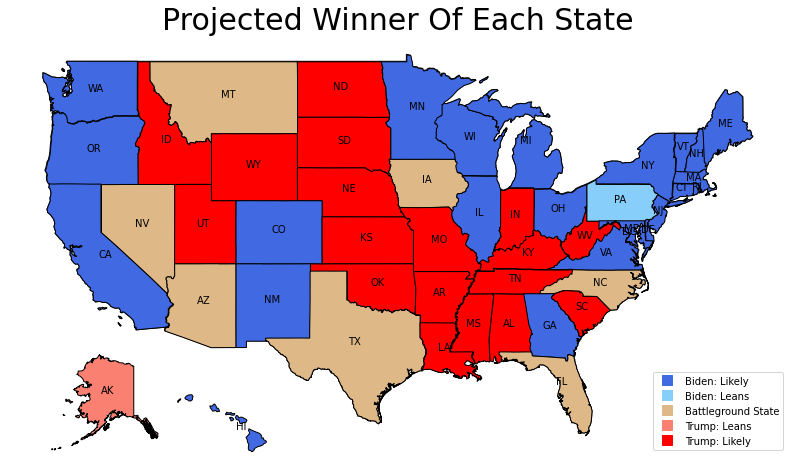

In [2]:
display(HTML('With the simulated results and the analyses conducted, we predict Joe Biden will accumulate a total of <b>{}</b> electoral votes versus Donald Trump, who is only projected to accumulate a total of <b>{}</b> electoral votes.'.format(total_votes_for_biden, total_votes_for_trump)))
  
# plot 1
plot_us_map_with_state_winner(votes_states_df)  

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

We further looked into the chances of each candidate winning the overall election. We simulated the polls in different state **1,000** times and we counted the total electoral votes for Biden for each simulation. We aggregated the results and plotted the histogram based on the results. Each blue bar represents the total number of times Biden won out of **1,000** simulations with that many total electoral votes. If the total electoral votes won by Biden is less than **270**, you would see a red bar which would mean Trump won that particular simulation.

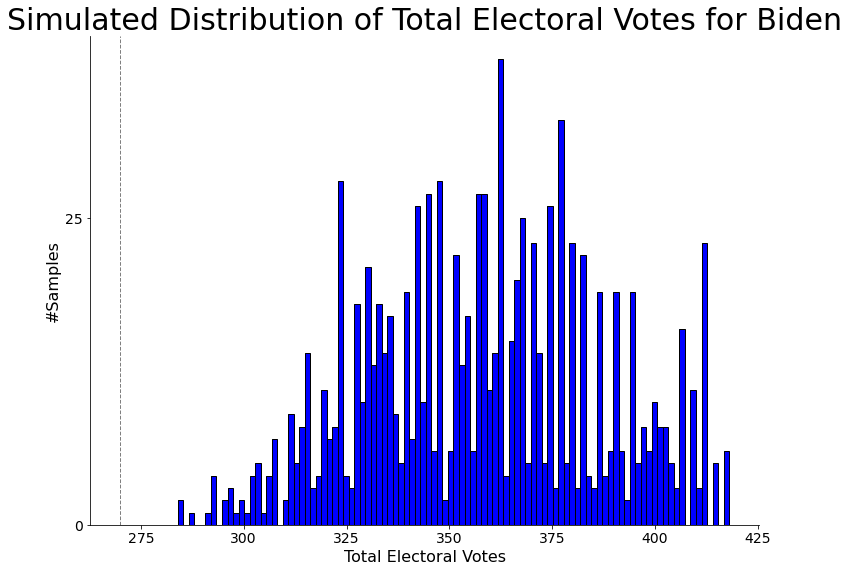

In [3]:

# plot 2
electoral_votes_for_biden_df = pd.DataFrame (total_electoral_votes,columns=['Total_Biden_Votes'])
plot_histogram_with_biden_votes (electoral_votes_for_biden_df)  

Based on the above distribution, it clearly shows that Biden will win **270**+ electoral votes making him the favorite to win this election.

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Battleground States

Based on our simulation the battleground states are the following:

In [4]:
for each_state in swing_states:
    display(HTML(each_state.capitalize()))


Below, we have broken down each battleground state to show how the poll results changed over time for each candidate.


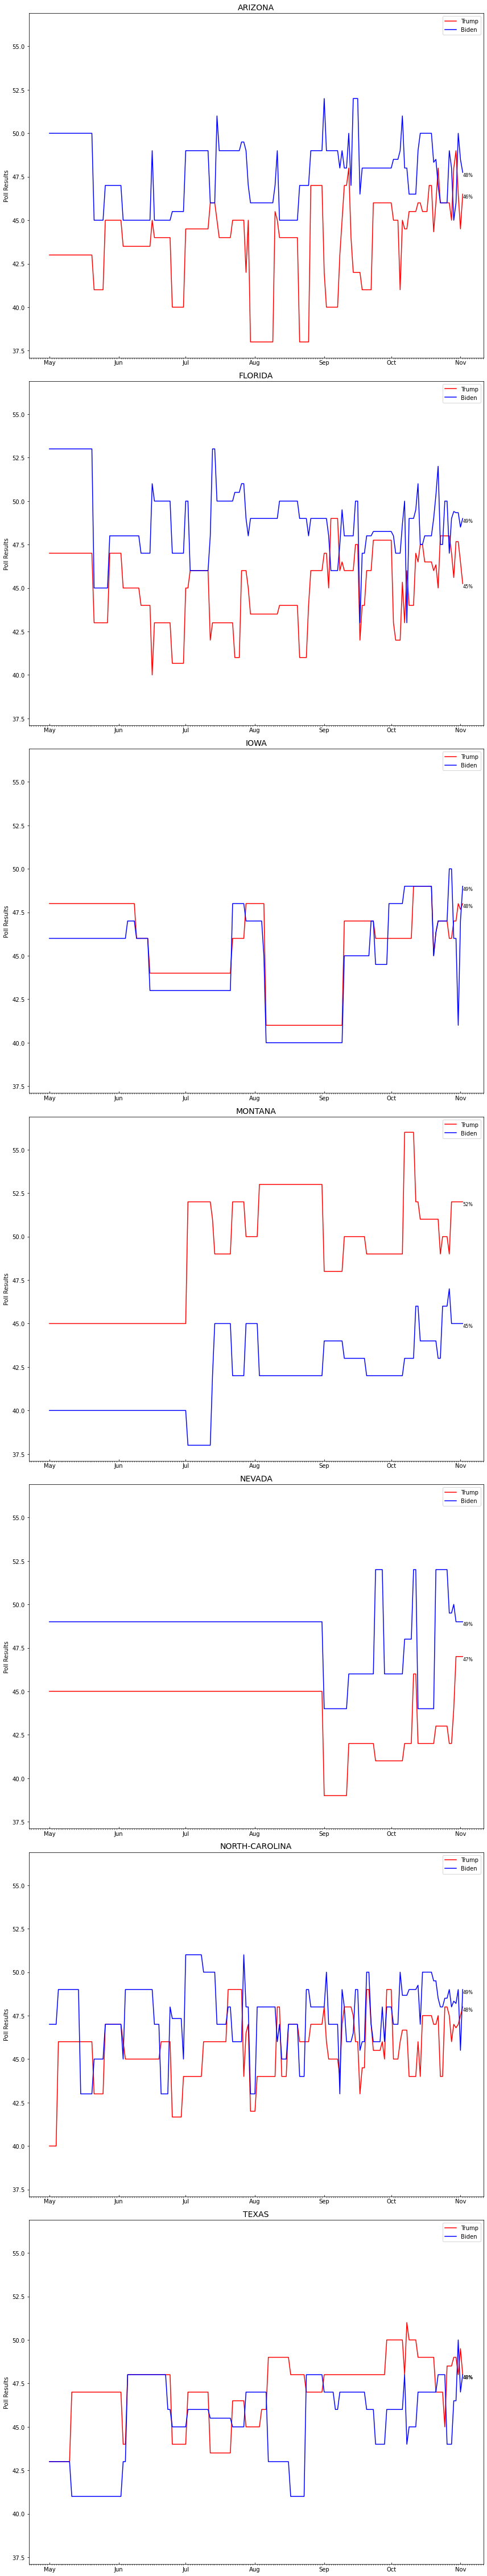

In [5]:
# final_battleground_state = poll_results_over_time(battleground_state,state_name)
poll_df = pd.read_csv(file_path+os.sep+'poll_df.csv', index_col=0, parse_dates=True)
plot_timeseries_for_battleground_States(poll_df, swing_states)

Assumptions:

1. We have used the average poll results if there were multiple polls conducted on the same day. 
2. We are not showing any results prior to May 2020 (because there were very few polls conducted and the visual was flat from that date to next poll date)
3. We don't have continuous poll results on a daily basis, so we plotted the same poll result until the next poll date.

<hr style="height:1px;border:none;color:#333;background-color:#333;" />



## Conclusion

In [6]:
display(HTML('Our early predictions show that <b>Joe Biden</b> leads the election in the state polls by a wide margin. With the final electoral college votes totalling <b>{}</b>, Joe Biden is projected to be the <b>46th President</b> of the United States of America. Due to the way the voting system is designed with electoral college votes, the U.S Election tends be decided by a handful of “battleground” states. With Biden projected to win most of these states, that could be the difference maker in the 2020 election. However, this does not mean Biden is guaranteed a victory over Trump. There could be inaccurate data from the battleground state polls in which support for Biden is overestimated or support for Trump is underestimated. Trump will need to win out in several battleground states if he hopes to upset Biden this election. November 3rd, 2020 will be an important day for the United States as Americans will vote for their next President of either Donald Trump or Joe Biden. Stay tuned!'.format(total_votes_for_biden)))